This notebook was made with reference from this kaggle notebook: https://www.kaggle.com/code/prasadiw/time-series-forecasting-stock-prices

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
df_log = pd.read_csv("./data/processed/mastercard_stock_history_processed.csv")

df_log["Date"] = pd.to_datetime(df_log['Date'], infer_datetime_format=True)
df_log.set_index('Date', inplace = True)
df_log.head()

C:\Users\proki\AppData\Local\Temp\ipykernel_13992\3802708126.py:8: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df_log["Date"] = pd.to_datetime(df_log['Date'], infer_datetime_format=True)


,Close
Date,
2006-05-25,1.453770
2006-05-26,1.430235
2006-05-30,1.409318
2006-05-31,1.430457
2006-06-01,1.486069


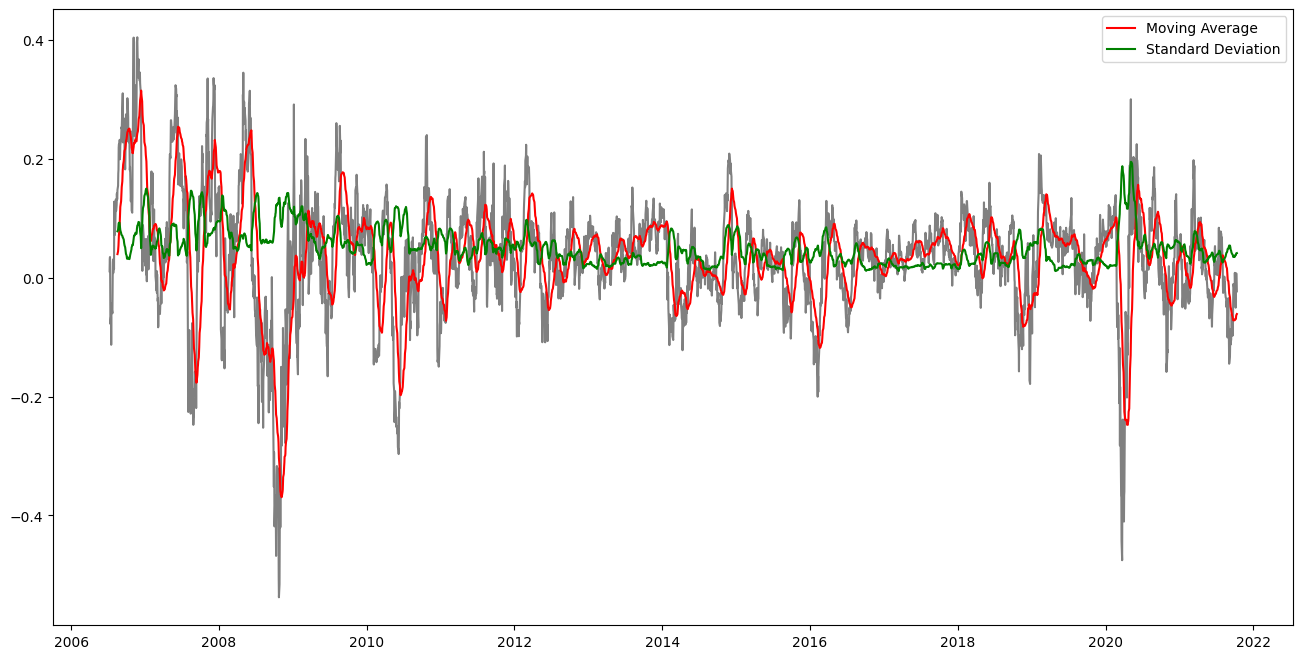

In [82]:
plt.figure(figsize=(16,8))
df_shift = df_log - df_log.shift(periods = 30)
MAvg_shift = df_shift.rolling(window=30).mean()
MStd_shift = df_shift.rolling(window=30).std()
plt.plot(df_shift, color='grey')
plt.plot(MAvg_shift, color='red', label = 'Moving Average')
plt.plot(MStd_shift, color='green', label = 'Standard Deviation')
plt.legend()
plt.show()

# Dropping the null values that we get after applying differencing method
df_shift = df_shift.dropna()

<Figure size 1600x800 with 0 Axes>

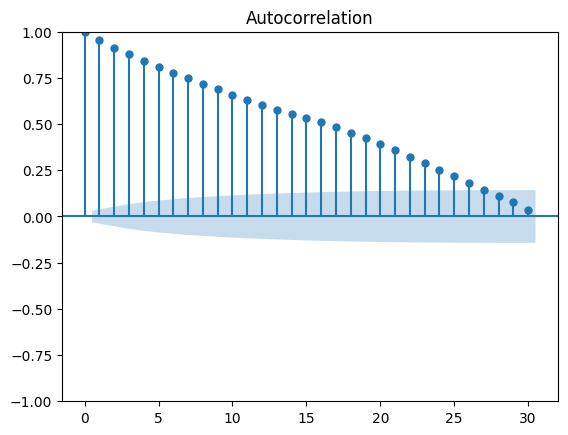

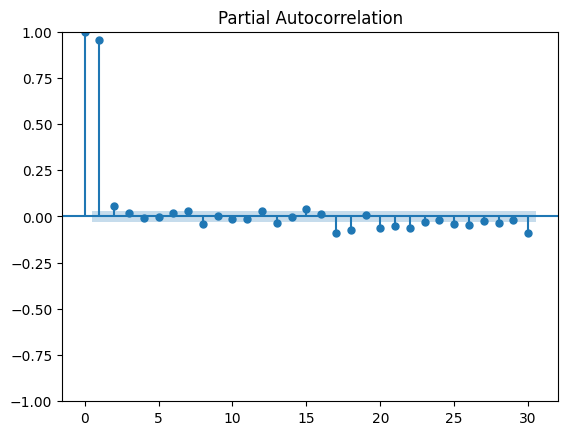

In [83]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(16, 8))
plot_acf(df_shift, lags = 30)
plt.show()
plot_pacf(df_shift, lags = 30)
plt.show()

In [84]:
df_shift.head()

,Close
Date,
2006-07-10,0.010596
2006-07-11,0.031115
2006-07-12,0.034621
2006-07-13,-0.004908
2006-07-14,-0.077888


From the graph, we can try:
1. p = 3 (highest lag that falls outside the statistically significant boundary in the PACF plot is 3)
2. q = 26 (highest lag falling outside statistically significant boundary in ACF plot is 26)
3. d = 0 (We have determined via ADF that the time series is stationary)

## Splitting of data into train and test sets

In [85]:
# code to find out the date at the 80th percentile of the dataframe
train_end_id = round((len(df_shift) - 1) * 0.8)
test_start_id = train_end_id + 1


In [86]:
df_train = df_shift.iloc[:test_start_id] # because iloc is exclusive
df_test = df_shift.iloc[test_start_id:]
print(df_train)
print(df_test)

               Close
Date                
2006-07-10  0.010596
2006-07-11  0.031115
2006-07-12  0.034621
2006-07-13 -0.004908
2006-07-14 -0.077888
...              ...
2018-09-17  0.073153
2018-09-18  0.087867
2018-09-19  0.074034
2018-09-20  0.087410
2018-09-21  0.086070

[3074 rows x 1 columns]
               Close
Date                
2018-09-24  0.088265
2018-09-25  0.093416
2018-09-26  0.086316
2018-09-27  0.104556
2018-09-28  0.089264
...              ...
2021-10-05 -0.050563
2021-10-06 -0.036853
2021-10-07 -0.013296
2021-10-08  0.007196
2021-10-11 -0.023152

[768 rows x 1 columns]


## AR Model

Fitting and predict the shifted series with the AR Model and calculate the RMSE.

c:\Users\proki\repos\ML\time-series-stocks\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

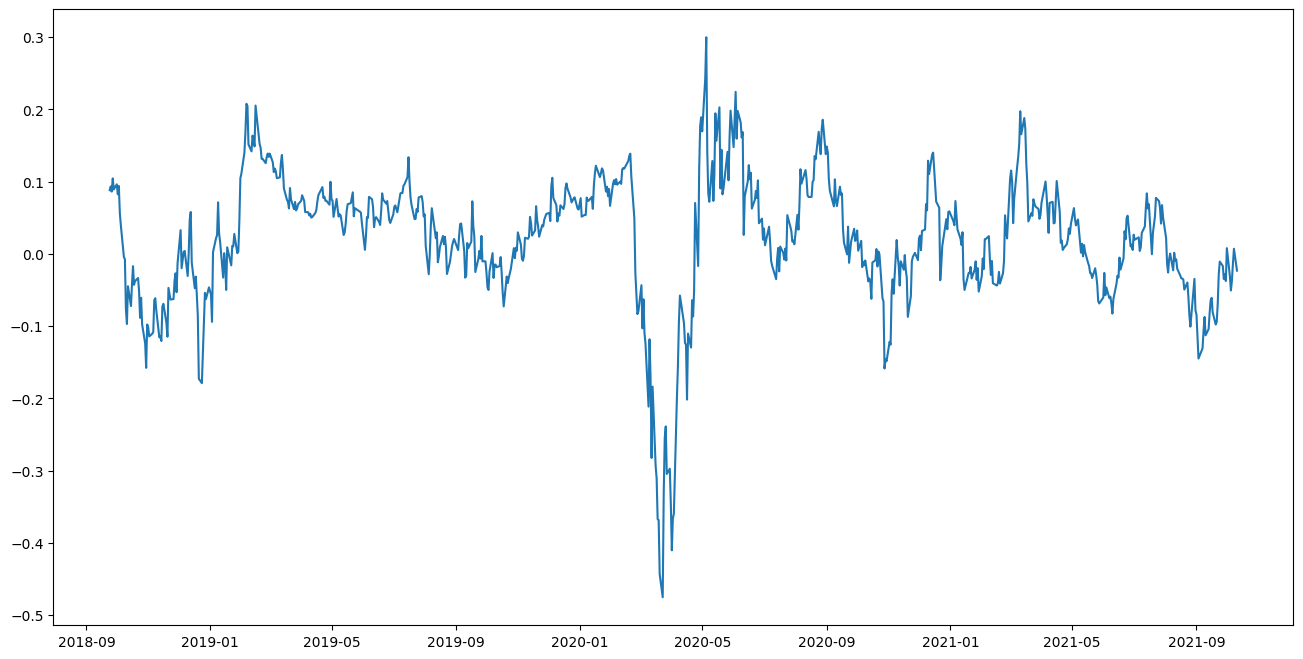

In [87]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

plt.figure(figsize=(16, 8))
m_AR = AutoReg(df_train, lags=3).fit() # p = AR(p = 3)
plt.plot(df_test)
prediction = m_AR.predict(start=df_test.index[0], end=df_test.index[-1]).fillna(0)
# prediction = m_AR.predict(start=0, end=len(df_test) - 1).fillna(0)
plt.plot(prediction, color="red")
plt.title('AR Model with RMSE = %.2f' % mean_squared_error(prediction, df_test["Close"]))
plt.show()

Let's build MA, ARMA, and ARIMA models as well and see if we can get a better model